In [1]:
import pandas as pd
import numpy as np
from random import sample
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
columns = ['Out'] + list(range(1,257))
trainingDF = pd.read_csv("1646102559_507402_train35.txt", names=columns)

In [3]:
samples = trainingDF.shape[0]
labels = trainingDF.shape[1]

In [4]:
trainingDF["weights"] = 1/samples

In [5]:
Y = trainingDF['Out']

In [6]:
def GetCountMatrix(value, A, Y):
    c = [0, 0, 0, 0]
    B = np.concatenate((A,Y), axis = None)
    B = np.reshape(B, (2,1214)).T
    c[0] = np.count_nonzero((B[:,0] >= value) &(B[:,1] == 5))
    c[1] = np.count_nonzero((B[:,0] < value) &(B[:,1] == 5))
    c[2] = np.count_nonzero((B[:,0] >= value) &(B[:,1] == 3))
    c[3] = np.count_nonzero((B[:,0] < value) &(B[:,1] == 3))    
        
    return c

In [7]:
def Gini(c):
    try:
        p = c[0]
        q = c[0] + c[2]
        p = p/q
        giniN1 = (2 * p*( 1 - p) )        
        
        r = c[1]
        s = c[1] + c[3]
        r = r/s
        giniN2 = (2 * r*( 1 - r) )        
        
    except ZeroDivisionError:
        return 1
    
    gini = ((q) * giniN1) + ((s) * giniN2 )
    
    return gini / 1214

In [8]:
def GetGini(A, Y) :
    g = []    
    U = np.unique(A)
    for i in range(0, U.shape[0]) :
        c = GetCountMatrix(U[i], A, Y)
        gini = Gini(c)
        if gini == 1:
            continue
        g.append([i] + [gini])
    if len(g) == 0:
        return 1
    g = np.array(g)
    split = g[:,-1].argmin()
    
    it = int(g[split][0])
    ming = g[split][1]
    
    i = list(A).index(U[it])
    return [i, ming]

In [9]:
def weakClassifier(A, Y):
    G = []    
    for i in range(1, 256):
        giniIndex = GetGini(A[i], Y)
        if giniIndex == 1:
            continue
        G.append([i] + giniIndex )
    
    A = np.array(A)
    G = np.array(G)
    Split = G[:,-1].argmin()
    feature = int(G[Split][0])
    row = int(G[Split][1])
    value = A[row][feature]
    c = GetCountMatrix(value, A[:,feature], Y)
    if c[0] > c[2]:
        left = 5
    else:
        left = 3
    if c[1] > c[3]:
        right = 5
    else:
        right = 3
    return [feature, value, left, right]

In [10]:
def predict(D, C):
    feature = C[0]
    value = C[1]
    left = C[2]
    right = C[3]
    Y = []
    for i in D[feature]:
        if i >= value:
            Y.append(left)
        else:
            Y.append(right)
    return Y

In [11]:
%%time  
C1 = weakClassifier(trainingDF, Y)


CPU times: user 2.32 s, sys: 26 ms, total: 2.34 s
Wall time: 2.35 s


In [12]:
YPred = predict(trainingDF, C1)
print(len(Y))

1214


In [13]:
count = 0
for i in range(0, len(YPred)):
    if YPred[i] == trainingDF['Out'][i]:
        count += 1
print(count/ len(YPred))

0.8467874794069192


Adaboost Implementation

In [14]:
def updateWeights(D, alpha):
    D['updatedWeights'] = 0
    D.loc[D['Out'] == D['predicted'], 'updatedWeights'] = np.exp(-1 * alpha)
    D.loc[D['Out'] != D['predicted'], 'updatedWeights'] = np.exp(alpha)
    D['updatedWeights'] = D['updatedWeights']*D['weights']
    D['weights'] = D['updatedWeights']/ D['updatedWeights'].sum()
    return D

In [15]:
def Classifier(giniI, D, alpha):
    
    D['TestOut'] = predict(D.iloc[:,1:256], giniI[1])
    D['TestOut'] = D['TestOut'].map({5: 5, 3: -3})
    Total = alpha[1] * D['TestOut']
    for i in range(2,len(giniI)):
        D['TestOut'] = predict(D.iloc[:,1:256], giniI[i])
        D['TestOut'] = D['TestOut'].map({5: 5, 3: -3})
        Total += alpha[i] * D['TestOut']

    YPred = np.sign(list(Total))
    YPred = np.where(YPred >= 0, 5, YPred)
    YPred = np.where(YPred < 0, 3, YPred)

    return YPred

In [145]:
def AdaBoost(D, k):
    alpha = [0]
    giniI = [0]
    Error = []
    for i in range(1, k):
        D1 =  D.sample(samples, replace = True, weights = D['weights'])
        gini = weakClassifier(D1.iloc[:,1:256], D1['Out'])
        D['predicted'] = predict(D.iloc[:,1:256], gini)
        D.loc[D['Out'] != D['predicted'], 'prediction'] = 1
        D.loc[D['Out'] == D['predicted'], 'prediction'] = 0
        E = (D['prediction'] * D['weights']).sum()
        if i%25 == 0:
            Error.append(E)
        if E > 0.5:
            D['weights'] = 1/samples
        giniI.append(gini)
        alpha.append(0.5*np.log((1-E)/E))
        D = updateWeights(D, alpha[i] )
    
    return giniI, alpha, Error

In [146]:
%%time  
giniI, alpha, Error = AdaBoost(trainingDF, 200)


CPU times: user 4min 3s, sys: 1.72 s, total: 4min 5s
Wall time: 4min 6s


In [142]:
YPred = Classifier(giniI,trainingDF, alpha)

In [143]:
def Accuracy(Ypred, Y):
    count = 0
    for i in range(0, Ypred.shape[0]):
        if Ypred[i] == Y[i]:
            count += 1
    return count/ Ypred.shape[0]

In [144]:
Accuracy(YPred, trainingDF['Out'])

0.8434925864909391

In [22]:
testDF = pd.read_csv("1646102559_513849_test35-nolabels.txt", names= list(range(1,257)))

In [23]:
YTest = Classifier(giniI, testDF, alpha)


In [24]:
print(YTest.shape[0])

326


In [127]:
Ypred = []
j= 0 
Tpred = []
TrainingError = []
for i in range(2, 200, 25):
    Ypred.append(Classifier(giniI[0:i], trainingDF, alpha[0:i]))
    Tpred.append(Classifier(giniI[0:i], testDF, alpha[0:i]))
    Yo = Ypred[j]    
    j += 1
    TrainingError.append(1 - Accuracy(Yo, Y))

In [128]:
def testFiles(Tpred):
    for i in range(0,len(Tpred)):
        file = open("Out"+ str(i)+ ".txt", "w")
        for j in Tpred[i]:
            file.write(str(int(j)) + "\n")
        file.close()

In [129]:
testFiles(Tpred)

In [130]:
classify = DecisionTreeClassifier()
classify = classify.fit(trainingDF.iloc[:,1:257],Y)
Yr = classify.predict(trainingDF.iloc[:,1:257])
Ye = classify.predict(testDF.iloc[:,1:257])

In [131]:
Accuracy(Yr,Y)

1.0

In [132]:
Ye = [Ye]
testFiles(Ye)

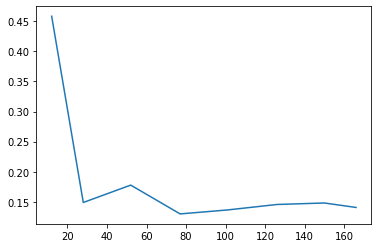

In [159]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from scipy.interpolate import make_interp_spline
xpoints = np.array(TrainingError)
ypoints = np.array(list(range(2, 200, 25)))
x2points = np.array([0.5, 0.28, 0.27, 0.21, 0.21, 0.17, 0.16, 0.16])
x3points = np.array([0.1]*8)
x4points = np.array([0.471, 0.29, 0.36, 0.57, 0.31, 0.50, 0.19, 0.32])
from scipy.ndimage.filters import gaussian_filter1d

ysmoothed = gaussian_filter1d(ypoints, sigma=1)

plt.plot(ysmoothed, xpoints )
plt.show()

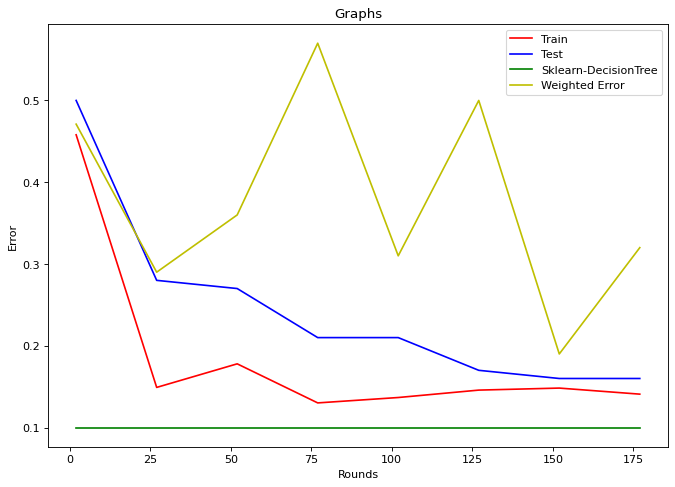

In [160]:

figure(figsize=(10, 7), dpi=80)
plt.plot(ypoints, xpoints, color='r', label='Train')
plt.plot(ypoints, x2points, color='b', label='Test')
plt.plot(ypoints, x3points, color='g', label='Sklearn-DecisionTree')
plt.plot(ypoints, x4points, color='y', label='Weighted Error')





plt.xlabel("Rounds")
plt.ylabel("Error")
plt.title("Graphs")

plt.legend()
  
plt.savefig('testplot.jpg')


plt.show()


